In [57]:
import json
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.models as models
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
def preprocess(text:str, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if re.match(r'(\d.|\d)', lemma) is None:
                if lemma not in stop_words:
                    preprocessed_text.append(lemma)
    return preprocessed_text

def read_json(path: str):
    file = open(path)
    data = json.load(file)
    return pd.DataFrame(data)

def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(sim.size):
        if df['need_match'][i]:
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

def calc_accuracy(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
    return round(float((TP + TN) / (TP + TN + FP + FN)), 3)


punctuation_marks = ['!', ',', '(', ')', ';', ':', '-', '?', '.', '..', '...', "\"", "/", "\`\`", "»", "«" ]
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [89]:
class ModelResearcher:
    def __init__(self):
        self.model = None
    
    def preprocess_and_save(self, data_df: pd.DataFrame, path, text_field='text') -> pd.DataFrame:
        # for preprocessing dataset. Use it only in critical cases cause it's too slow on big datasets
        data_df['preprocessed_' + text_field] = data_df.apply(lambda row: preprocess(row[text_field], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def preprocess_and_save_pairs(self, data_df: pd.DataFrame, path, text_field_1, text_field_2) -> pd.DataFrame:
        data_df['preprocessed_' + text_field_1] = data_df.apply(lambda row: preprocess(row[text_field_1], punctuation_marks, stop_words, morph), axis=1)
        data_df['preprocessed_' + text_field_2] = data_df.apply(lambda row: preprocess(row[text_field_2], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field_1, text_field_2], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def train(self, data_df: pd.DataFrame, model="w2v"):            
        if model == "w2v":
            train_part = data_df['preprocessed_texts']
            self.model = gensim.models.Word2Vec(sentences=train_part, min_count=5, vector_size=50, epochs=5)
            self.model.save('w2v')
        elif model == "fast_text":
            train_part = data_df['preprocessed_texts'].tolist()
            self.model = gensim.models.FastText(vector_size=50, min_count=5)
            self.model.build_vocab(corpus_iterable=train_part)
            self.model.train(corpus_iterable=train_part, total_examples=len(train_part), epochs=5)
            self.model.save('fastText')
        return

                    
    
    def predict_sentences_similarity(self, sentences_1: pd.Series, sentences_2: pd.Series):
        if sentences_1.size != sentences_2.size:
            return None
        else:
            if self.model is not None:
                sentences_sim = np.zeros(sentences_1.size)
                sz = sentences_1.size
                for i in range(sz): 
                    sentences_1_words = [w for w in sentences_1[i] if w in self.model.wv.index_to_key]
                    sentences_2_words = [w for w in sentences_2[i] if w in self.model.wv.index_to_key]
                    sim = self.model.wv.n_similarity(sentences_1_words, sentences_2_words)
                    sentences_sim[i] = sim
                
                return sentences_sim
            else:
                return None
        
    def get_train_test_dfs_for_f1(self, df_match, df_unmatch): 
        df_match = shuffle(df_match)
        df_unmatch = shuffle(df_unmatch)
        
        df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
        df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
        return (df_train_f1, df_test_f1)
    
    
    def get_optimal_threshold(self, sentences_1: pd.Series, sentences_2: pd.Series, df, step=0.02):
        if sentences_1.size != sentences_2.size or self.model is None:
            return None
        else:
            threshold = 0
            thresholds = []
            max_ = 0
            h = step
            steps = np.linspace(0, 1, num=int(1/h))
            steps = np.round(steps, 2)
            for i in steps:
                sim =  self.predict_sentences_similarity( sentences_1, sentences_2)
                threshold = calc_f1_score(sim, df, h)
                print(h, threshold)
                thresholds.append(threshold)
                if threshold > max_:
                    max_ = threshold
                h += step
            plt.plot(steps, thresholds)
            plt.figure(figsize=(10,3))
            plt.show()
            
            return max_

## Обучим word2vec

In [142]:
data_df = read_json('./preprocessed_documents.json')
modelResearcher_w2v = ModelResearcher()
# modelResearcher_w2v.train(data_df, model="w2v")
modelResearcher_w2v.model = models.ldamodel.LdaModel.load('./w2v')
modelResearcher_w2v.model

In [143]:
match_unmatch_df = read_json('./dataset.json')

In [144]:
match_unmatch_df

,id_rp,id_proj,name_rp,name_proj,text_rp,text_proj,need_match
0,1000,15,АЛГОРИТМЫ БЕСПИЛОТНОГО ТРАНСПОРТА,Разработка системы движения роя дронов в прост...,Данный курс знакомит слушателей с основами упр...,Разработка системы движения роя дронов в прост...,True
1,1005,40,АНАЛИЗ ДАННЫХ В ИСКУССТВЕННОМ ИНТЕЛЛЕКТЕ,Роботизированная система машинного творчества ...,Освещаемые в курсе теоретические и прикладные ...,Роботизированная система машинного творчества ...,True
2,1009,4,РАЗРАБОТКА ПРИЛОЖЕНИЙ В РАСПРЕДЕЛЕННОЙ СРЕДЕ,Разработка модулей обработки данных для библио...,Дисциплина посвящена изучению основных принцип...,Разработка модулей обработки данных для библио...,True
3,1011,14,Тестирование и сопровождение программного обес...,Тестирование и документирование стенда виртуал...,"Цели дисциплины охватывают ряд направлений, св...",Тестирование и документирование стенда виртуал...,True
4,1016,46,Интеллектуальные системы,Разработка интеллектуальных модулей обработки ...,Рассматриваются основные понятия теории интелл...,Разработка интеллектуальных модулей обработки ...,True
5,105,41,Системы управления манипуляторными роботами,Разработка подводного телеуправляемого робота ...,Дисциплина включает изложение основ теории ман...,Разработка подводного телеуправляемого робота ...,True
6,1040,26,Управление и информатика в технических системах,Программно-аппаратное конфигурирование сети ла...,В рамках данной дисциплины рассматриваются осн...,Программно-аппаратное конфигурирование сети ла...,True
7,1278,9,Тестирование программного обеспечения,Тестирование конфигураций на платформах: Super...,Дисциплина посвящена изучению теоретических ос...,Тестирование конфигураций на платформах: Super...,True
8,991,30,Машинное обучение,Разработка системы детектирования и идентифика...,Данный курс знакомит слушателей с основными ме...,Разработка системы детектирования и идентифика...,True
9,985,8,Основы компьютерного дизайна,"Разработка ИС ""Расписание"" / ""Деканат"".",В курсе рассматриваются свойства зрительного в...,"Разработка ИС ""Расписание"" / ""Деканат"". Информ...",True


In [145]:
df_match = match_unmatch_df[ match_unmatch_df['need_match'] == True][:-2]
df_unmatch = match_unmatch_df[match_unmatch_df['need_match'] == False]

df_train_f1, df_test_f1 = modelResearcher_w2v.get_train_test_dfs_for_f1(df_match, df_unmatch)

In [146]:
print('df_train: {} of {}'.format(df_train_f1['id_rp'].size, match_unmatch_df ['id_rp'].size))
print('df_test: {} of {}'.format(df_test_f1['id_rp'].size,match_unmatch_df['id_rp'].size))

df_train: 22 of 46
df_test: 22 of 46


In [147]:
df_train_f1 = modelResearcher_w2v.preprocess_and_save_pairs(df_train_f1, None, 'text_rp', 'text_proj')
df_test_f1 = modelResearcher_w2v.preprocess_and_save_pairs(df_test_f1, None, 'text_rp', 'text_proj')

In [148]:
result_w2v_train = modelResearcher_w2v.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
print(result_w2v_train)

[0.80311489 0.80061388 0.81609064 0.89000744 0.86433655 0.78473049
 0.72926593 0.72943348 0.90860891 0.86129117 0.59405261 0.1579898
 0.64158523 0.67159766 0.47628844 0.38284627 0.72230852 0.76301932
 0.56604397 0.86674094 0.74218744 0.39362508]


0.02 0.667
0.04 0.667
0.06 0.667
0.08 0.667
0.1 0.667
0.12000000000000001 0.667
0.14 0.667
0.16 0.688
0.18 0.688
0.19999999999999998 0.688
0.21999999999999997 0.688
0.23999999999999996 0.688
0.25999999999999995 0.688
0.27999999999999997 0.688
0.3 0.688
0.32 0.688
0.34 0.688
0.36000000000000004 0.688
0.38000000000000006 0.688
0.4000000000000001 0.733
0.4200000000000001 0.733
0.4400000000000001 0.733
0.46000000000000013 0.733
0.48000000000000015 0.759
0.5000000000000001 0.759
0.5200000000000001 0.759
0.5400000000000001 0.759
0.5600000000000002 0.759
0.5800000000000002 0.786
0.6000000000000002 0.741
0.6200000000000002 0.741
0.6400000000000002 0.741
0.6600000000000003 0.769
0.6800000000000003 0.8
0.7000000000000003 0.8
0.7200000000000003 0.8
0.7400000000000003 0.727
0.7600000000000003 0.762
0.7800000000000004 0.8
0.8000000000000004 0.737
0.8200000000000004 0.5
0.8400000000000004 0.5
0.8600000000000004 0.5
0.8800000000000004 0.308
0.9000000000000005 0.167
0.9200000000000005 0.0
0.9400000000

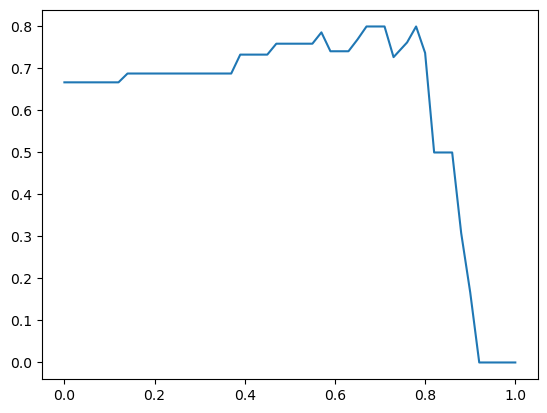

<Figure size 1000x300 with 0 Axes>

In [149]:
result_w2v_train_opt = modelResearcher_w2v.get_optimal_threshold(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'], df_train_f1, 0.02)

In [150]:
print(result_w2v_train_opt)

0.8


In [151]:
f1_w2v_train = calc_f1_score(result_w2v_train, df_train_f1, result_w2v_train_opt)
acc_w2v_train = calc_accuracy(result_w2v_train, df_train_f1, result_w2v_train_opt)
print('F1-score train w2v: {}'.format(f1_w2v_train ))
print('accuracy train w2v: {}'.format(acc_w2v_train))
df_train_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_train_f1.insert(loc=4, column='score', value=result_w2v_train) 
# df_train_f1

F1-score train w2v: 0.737
accuracy train w2v: 0.773


In [152]:
result_w2v_test = modelResearcher_w2v.predict_sentences_similarity(df_test_f1['preprocessed_text_rp'], df_test_f1['preprocessed_text_proj'])
f1_w2v_test = calc_f1_score(result_w2v_test, df_test_f1, result_w2v_train_opt)
acc_w2v_test = calc_accuracy(result_w2v_test, df_test_f1, result_w2v_train_opt)
print('F1-score test w2v: {}'.format(f1_w2v_test))
print('accuracy test w2v: {}'.format(acc_w2v_test))

F1-score test w2v: 0.533
accuracy test w2v: 0.682


In [153]:
df_test_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_test_f1.insert(loc=4, column='score', value=result_w2v_test) 
df_test_f1[8:]

,id_rp,id_proj,name_rp,name_proj,score,need_match,preprocessed_text_rp,preprocessed_text_proj
8,4776,11,Web-технологии,Анализ динамики COVID-19 в России,0.772965,True,"[курс, web-технология, охватывать, широкий, сп...","[анализ, динамика, covid-19, россия, ·, web-пр..."
9,105,41,Системы управления манипуляторными роботами,Разработка подводного телеуправляемого робота ...,0.622302,True,"[дисциплина, включать, изложение, основа, теор...","[разработка, подводный, телеуправляемый, робот..."
10,1005,40,АНАЛИЗ ДАННЫХ В ИСКУССТВЕННОМ ИНТЕЛЛЕКТЕ,Роботизированная система машинного творчества ...,0.784002,True,"[освещать, курс, теоретический, прикладной, во...","[роботизированный, система, машинный, творчест..."
11,2163,31,Аудиотехника,Определение состояния автомобиля используя видео,0.666107,False,"[дисциплина, аудиотехника, изучать, особенност...","[определение, состояние, автомобиль, использов..."
12,5105,11,Дискретная математика и теоретическая информатика,Анализ динамики COVID-19 в России,0.536743,False,"[раздел, современный, математика, иметь, прило...","[анализ, динамика, covid-19, россия, ·, web-пр..."
13,4355,34,Базы данных,Разработка модулей «Кафедра» и «Деканат-2» для...,0.725642,False,"[дисциплина, посвятить, знакомство, основный, ...","[разработка, модуль, кафедра, деканат-2, новый..."
14,4769,34,Введение в нереляционные системы управления ба...,Разработка модулей «Кафедра» и «Деканат-2» для...,0.697231,False,"[дисциплина, знакомить, теоретический, практич...","[разработка, модуль, кафедра, деканат-2, новый..."
15,3490,57,"Спецификация, проектирование и архитектура про...",Стажировка в Digital Security по аудиту защищё...,0.743762,False,"[дисциплина, спецификация, проектирование, арх...","[стажировка, digital, security, аудит, защищён..."
16,4401,48,Проектирование встроенных приложений,Разработка рекомендательной машины,0.777739,False,"[настоящий, время, больший, доля, аппаратура, ...","[разработка, рекомендательный, машина, рекомен..."
17,6075,41,Методы оптимизации,Разработка подводного телеуправляемого робота ...,0.645628,False,"[рассматриваться, классификация, задача, метод...","[разработка, подводный, телеуправляемый, робот..."


## FastText

In [154]:
# modelResearcher_ft = ModelResearcher()
# data_df = read_json('./preprocessed_documents.json')
# modelResearcher_ft.train(data_df, model="fast_text")
# modelResearcher_ft.model.save('ft')

In [155]:
modelResearcher_ft = ModelResearcher()
modelResearcher_ft.model = models.ldamodel.LdaModel.load('./ft')

0.02 0.667
0.04 0.667
0.06 0.667
0.08 0.667
0.1 0.667
0.12000000000000001 0.667
0.14 0.667
0.16 0.667
0.18 0.667
0.19999999999999998 0.667
0.21999999999999997 0.667
0.23999999999999996 0.667
0.25999999999999995 0.667
0.27999999999999997 0.667
0.3 0.667
0.32 0.667
0.34 0.667
0.36000000000000004 0.667
0.38000000000000006 0.667
0.4000000000000001 0.667
0.4200000000000001 0.667
0.4400000000000001 0.667
0.46000000000000013 0.667
0.48000000000000015 0.667
0.5000000000000001 0.688
0.5200000000000001 0.688
0.5400000000000001 0.688
0.5600000000000002 0.688
0.5800000000000002 0.688
0.6000000000000002 0.688
0.6200000000000002 0.688
0.6400000000000002 0.688
0.6600000000000003 0.71
0.6800000000000003 0.733
0.7000000000000003 0.759
0.7200000000000003 0.759
0.7400000000000003 0.815
0.7600000000000003 0.815
0.7800000000000004 0.72
0.8000000000000004 0.75
0.8200000000000004 0.818
0.8400000000000004 0.7
0.8600000000000004 0.667
0.8800000000000004 0.588
0.9000000000000005 0.4
0.9200000000000005 0.167
0.9

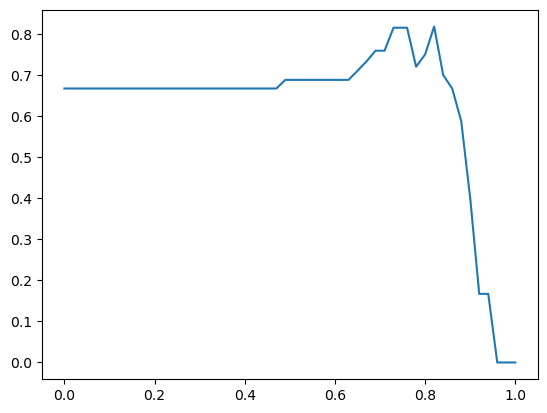

<Figure size 1000x300 with 0 Axes>

In [156]:
result_ft_train_opt = modelResearcher_ft.get_optimal_threshold(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'], df_train_f1, 0.02)

In [157]:
print(result_ft_train_opt)

0.818


In [158]:
result_ft_train = modelResearcher_ft.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
f1_ft_train = calc_f1_score(result_ft_train, df_train_f1, result_ft_train_opt)
acc_ft_train = calc_accuracy(result_ft_train, df_train_f1, result_ft_train_opt)
print('F1-score train ft: {}'.format(f1_ft_train ))
print('accuracy train ft: {}'.format(acc_ft_train ))
df_train_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_train_f1.insert(loc=4, column='score', value=result_ft_train) 

F1-score train ft: 0.818
accuracy train ft: 0.818


In [159]:
result_ft_test = modelResearcher_ft.predict_sentences_similarity(df_test_f1['preprocessed_text_rp'], df_test_f1['preprocessed_text_proj'])
f1_ft_test = calc_f1_score(result_ft_test, df_test_f1, result_ft_train_opt)
acc_ft_test = calc_accuracy(result_ft_test, df_test_f1, result_ft_train_opt)
print('F1-score test ft: {}'.format(f1_ft_test))
print('accuracy test ft: {}'.format(acc_ft_test ))
df_test_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_test_f1.insert(loc=4, column='score', value=result_ft_test) 

F1-score test ft: 0.762
accuracy test ft: 0.773
